# Project 1

In [146]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
# Importing standard libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample

In [225]:
# Importing project-specific files
from FrankeFunction import FrankeFunction, SimpleFunction
from MLFunctions import DesignMatrix, OLS_matrix_inversion, OLS_SVD, bias_variance_tradeoff
from MLFunctions import ridge_regression, lasso_regression
from MLFunctions import GradientDescent, MomentumGradientDescent
from Statistics import MSE, R2, norm2

In [ ]:
# Defining data set
step_size = 0.05
arr = np.arange(0, 1, step_size)

Mat = np.meshgrid(arr, arr)
data = FrankeFunction(*Mat, noise=0)

## Part a): Ordinary Least Square (OLS) on the Franke function
### Performing standard least square regression, and plotting the result.

In [ ]:
X = DesignMatrix(arr, arr, 5)               # defining design matrix
beta_inv = OLS_matrix_inversion(X, data)    # computing polynomal coefficients usnig matrix inversion
beta_svd = OLS_SVD(X, data)                 # computing polynomal coefficients usnig singular value decomp
model = X @ beta_inv

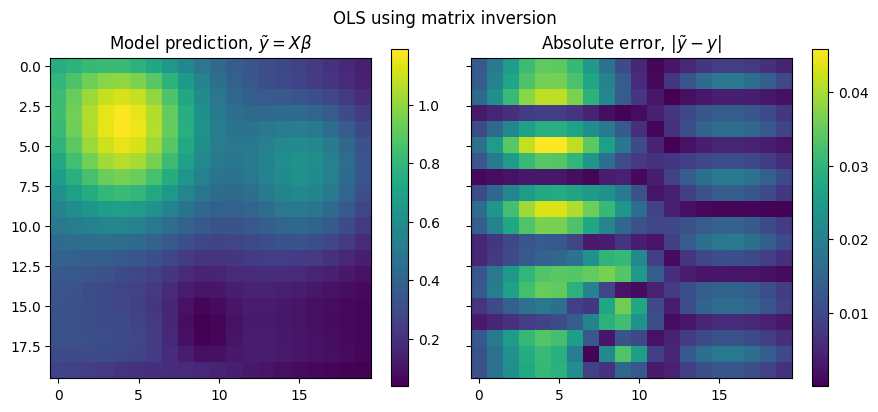

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("OLS using matrix inversion")
im0 = ax[0].imshow(model)
im1 = ax[1].imshow(abs(data - model))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

**Left plot:** Using matrix inversion to predict model of the Franke function without noise.  
**Right plot:** Absolute difference between model prediction and actual data.

In [ ]:
# Computing errors
mse = MSE(data, model)
r2 = R2(data, model)

print(f"Mean-square-error: {mse:0.6f}\nR^2 score function: {r2:0.6f}")

Mean-square-error: 0.000336
R^2 score function: 0.995886


The mean square error is very low, and the $R^2$ score function is close to 1, so our model is pretty good...

### Now, we split our data in sets of training data and testing data
Here, we want to discuss ways to scale and split data. Use between 0.6-0.8 of data as training data.

## Part b): Bias-variance trade-off and resamplng techniques
### First, makeing figure of prediction error vs model complexity, for test and training models

In [ ]:
Nreps = 100
max_degree = 15
test_size = 0.2 #1/3

In [ ]:
# empty arrays for storing result
MSE_train = np.zeros(max_degree)
MSE_test = np.zeros(max_degree)
#error = np.zeros_like(MSE_test)
#bias = np.zeros_like(MSE_test)
#var = np.zeros_like(MSE_test)


# looping through complexity
for i in range(max_degree):
    X = DesignMatrix(arr, arr, i)
    #X_, X_test, y_, y_test = train_test_split(X, data, test_size=test_size, random_state=r)
    #y_pred = np.zeros([Nreps, y_test.shape[0], y_test.shape[1]])
    #y_comp = np.zeros([Nreps, y_test.shape[0], y_test.shape[1]])
    
    # looping through repetitions
    for rep in range(Nreps):
        # performing OLS
        r = int(100 * np.random.rand())
        X_, X_test, y_, y_test = train_test_split(X, data, test_size=test_size, random_state=r)
        beta = OLS_matrix_inversion(X_, y_)

        # computing average
        MSE_train[i] += MSE(y_, X_ @ beta) / Nreps
        MSE_test[i] += MSE(y_test, X_test @ beta) / Nreps

        #y_pred[rep] = X_test @ beta
        #y_comp[rep] = y_test

        #print(MSE_test[i])

    #Exp_y = np.mean(y_pred, axis=0)
    #error[i] = np.mean( (y_comp - y_pred)**2 )
    #bias[i] = np.mean( (y_comp -  Exp_y)**2 )
    #var[i]  = np.mean( (y_pred -  Exp_y)**2 )

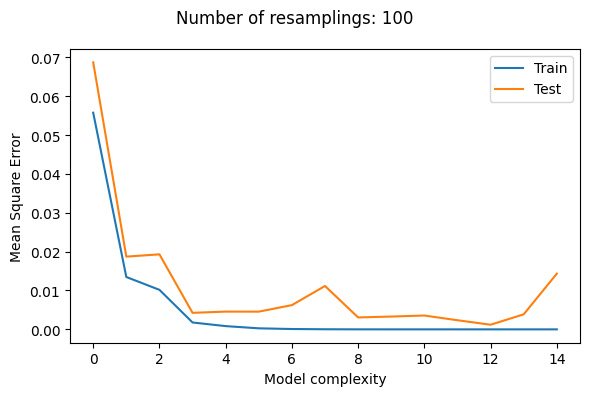

In [ ]:
complexity = np.arange(max_degree)

fig, ax = plt.subplots(1,1, figsize=(6,4))
fig.suptitle(f"Number of resamplings: {Nreps}")

ax.set(xlabel="Model complexity", ylabel="Mean Square Error")
ax.plot(complexity, MSE_train, label="Train")
ax.plot(complexity, MSE_test, label="Test")
#ax.plot(complexity, error, '-')
#ax.plot(complexity, bias+var, '--')
#ax.plot(complexity, var, '--')
ax.legend()

fig.tight_layout()

Whereas the error decreases with model complexity for the training data, the error on the test data increases at some point because of overtraining.
N.B.: here we have not yet used bootstrapping.

### Bias-variance analysis
The mean square error can be written as:
$E\left[(\mathbf{y} - \mathbf{\tilde{y}})^2\right] = \frac{1}{n}\sum_i (y_i - E[\tilde{\mathbf{y}}])^2 + \frac{1}{n}\sum_i (\tilde{y_i} - E[\tilde{\mathbf{y}}])^2 + \sigma^2$.

The first term, $\frac{1}{n}\sum_i (y_i - E[\tilde{\mathbf{y}}])^2$, is the square of the bias, because it is the difference between data points and prediction average, i.e. a measure of how far the center of our model is from the actual data it is trying to capture.

The second term, $\frac{1}{n}\sum_i (\tilde{y_i} - E[\tilde{\mathbf{y}}])^2 = E[\tilde{\mathbf{y}}^2] - E[\tilde{\mathbf{y}}]^2$, is the variance, which can be seen mathematically, or by realising that it is the mean squared error of our model.

### Performing the bias-variance analysis

In [ ]:
n_bootstraps = 100
max_degree = 12
test_size = 0.2

error, bias2, variance = bias_variance_tradeoff(data, arr, resampling_method='bootstrap', method_params=n_bootstraps, max_degree=max_degree, test_size=test_size)

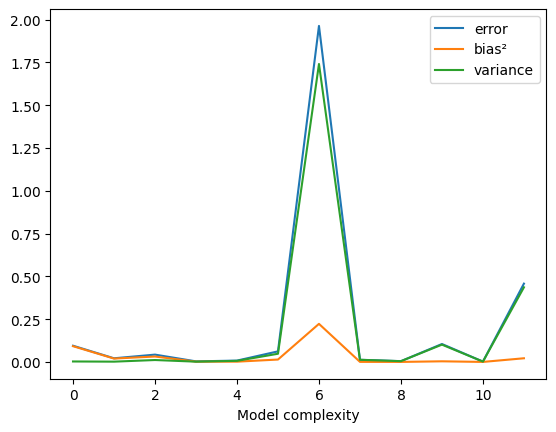

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(error, label="error")
ax.plot(bias2, label="bias²")
ax.plot(variance, label="variance")
ax.set(xlabel="Model complexity")

ax.legend();

Something is off here. Problem seems to come from resampling, since when modifying code generating MSE-figure it behaves similarily. Is bootstrapping implemented wrong?

## Part c): Cross-validation and resampling techniques
### Scale data

### Implement the k-fold cross-validation algorithm

In [ ]:
max_degree = 20
test_size = 0.1

error, bias2, variance = bias_variance_tradeoff(data, arr, method='cross-validation', max_degree=max_degree, test_size=test_size)


TypeError: bias_variance_tradeoff() got an unexpected keyword argument 'method'

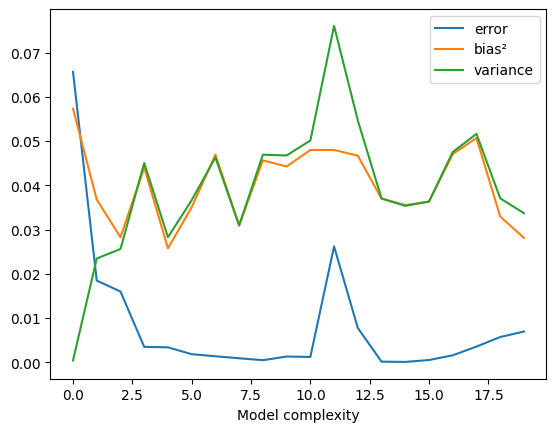

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(error, label="error")
ax.plot(bias2, label="bias²")
ax.plot(variance, label="variance")
ax.set(xlabel="Model complexity")

ax.legend();

## Part d): Ridge Regression on the Franke function with resampling

In [ ]:
lmbd = 0.1
beta_ridge = ridge_regression(X, data, lmbd)
model_ridge = X @ beta_ridge


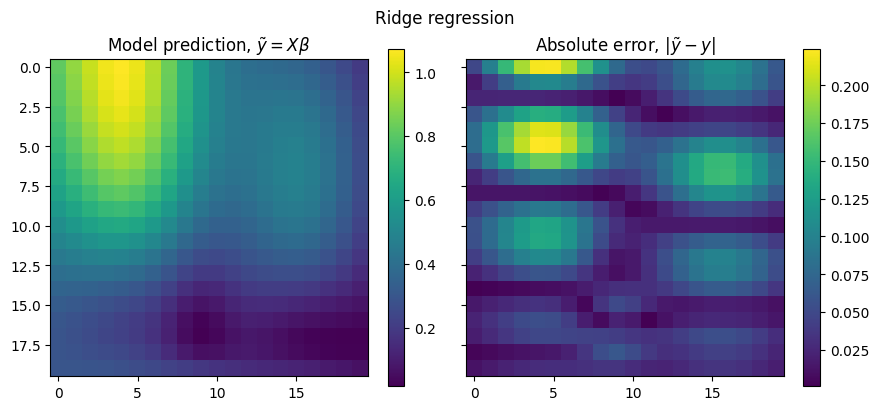

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("Ridge regression")
im0 = ax[0].imshow(model_ridge)
im1 = ax[1].imshow(abs(data - model_ridge))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

### Bootstrapping with Ridge regression

### Cross-validation with Ridge regression

### Bias-variance tradeoff

## Part e): Lasso regression

In [ ]:
lmbd = 0.1
beta_lasso, model_lasso = lasso_regression(X, data, lmbd)
model2_lasso = X @ beta_lasso.T


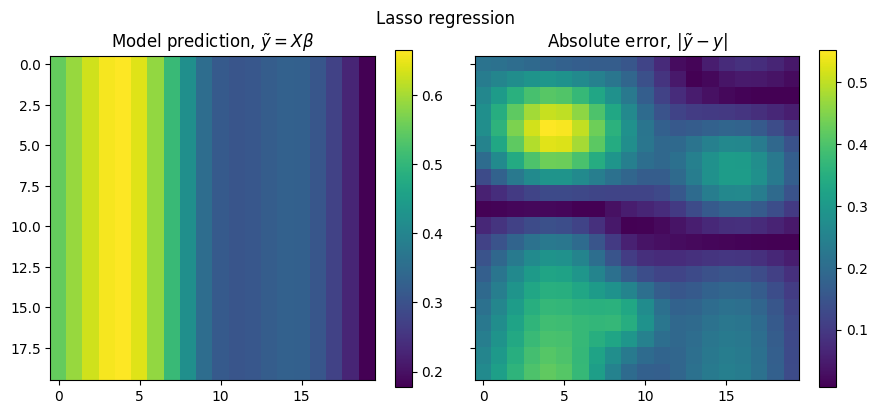

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("Lasso regression")
im0 = ax[0].imshow(model_lasso)
im1 = ax[1].imshow(abs(data - model_lasso))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

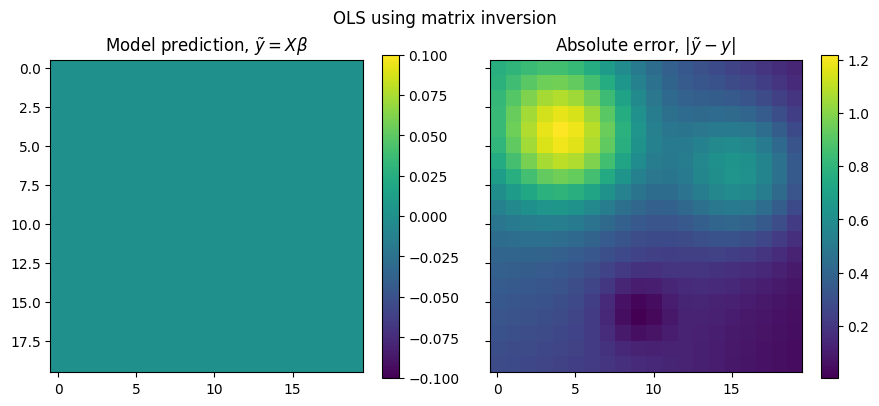

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("OLS using matrix inversion")
im0 = ax[0].imshow(model2_lasso)
im1 = ax[1].imshow(abs(data - model2_lasso))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

### Bootstrapping with Lasso regression

### Cross-validation with Lasso regression

### Bias-variance tradeoff

## Part f): Write your own Stochastic Gradient Descent code
### 1. Plain gradient descent with fixed learning rate

In [210]:
# defining dataset 
X = np.c_[np.ones_like(arr), arr, arr**2]
ndata, ndims = np.shape(X)

params = [2, 3, 4]
data = SimpleFunction(arr, params)

# performing gradient descent
tolerance = 1e-4
learning_rate = np.linspace(0.1, 1, 20)
niter_plain = np.zeros_like(learning_rate)
converged_plain = np.zeros_like(learning_rate)

i = 0
for lr in learning_rate:
    beta_temp, niter_plain[i] = GradientDescent(X, data, lr);
    if sum(beta_temp - params) < tolerance :
        converged_plain[i] = 1

    i += 1

/home/silja/Programs/miniconda3/envs/compsci/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/Statistics.py:20: RuntimeWarning: overflow encountered in square
  return max(np.sum(abs(M), 1))
/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/MLFunctions.py:248: RuntimeWarning: overflow encountered in matmul
  grad = (2.0 / ndata) * X.T @ (X @ beta - data)
/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/MLFunctions.py:248: RuntimeWarning: invalid value encountered in matmul
  grad = (2.0 / ndata) * X.T @ (X @ beta - data)
/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/MLFunctions.py:249: RuntimeWarning: invalid value encountered in subtract
  beta -= gamma * grad


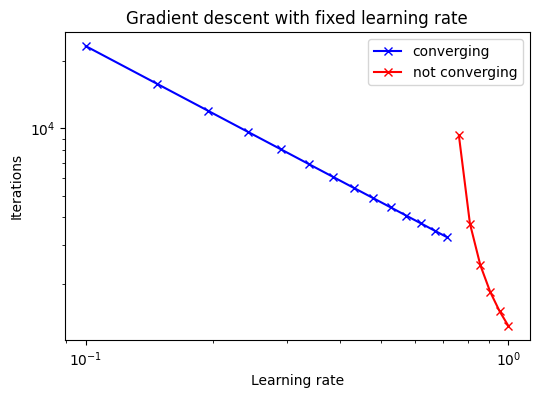

In [218]:
# tuning learning rate
fig, ax = plt.subplots(1, 1, figsize=(6,4));

ax.plot(learning_rate[converged_plain==1], niter_plain[converged_plain==1], 'bx-', label="converging");
ax.plot(learning_rate[converged_plain==0], niter_plain[converged_plain==0], 'rx-', label="not converging");

ax.set(title="Gradient descent with fixed learning rate", xlabel="Learning rate", ylabel="Iterations");
ax.set(xscale="log", yscale="log")
ax.legend();

# better way of evaluating result? Compute also cost function

### 2. Add momentum and compare convergence

/home/silja/Programs/miniconda3/envs/compsci/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/Statistics.py:20: RuntimeWarning: overflow encountered in square
  return max(np.sum(abs(M), 1))
/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/MLFunctions.py:280: RuntimeWarning: overflow encountered in matmul
/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/MLFunctions.py:280: RuntimeWarning: invalid value encountered in matmul
/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/MLFunctions.py:281: RuntimeWarning: invalid value encountered in add


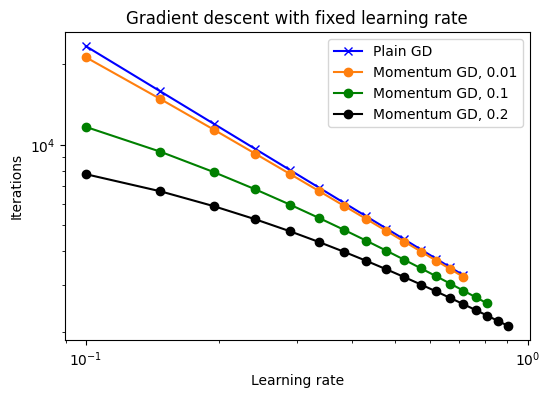

In [269]:
# tuning learning rate
fig, ax = plt.subplots(1, 1, figsize=(6,4));
ax.plot(learning_rate[converged_plain==1], niter_plain[converged_plain==1], 'bx-', label="Plain GD");

# performing gradient descent
momentum = [0.1, 0.2, 0.3]
color = ['tab:orange', 'g', 'k']

j = 0
for mom in momentum:
    niter_momentum = np.zeros_like(learning_rate)
    converged_momentum = np.zeros_like(learning_rate)

    i = 0
    for lr in learning_rate:
        beta_temp, niter_momentum[i] = MomentumGradientDescent(X, data, lr, mom);
        if sum(beta_temp - params) < tolerance :
            converged_momentum[i] = 1

        i += 1

    ax.plot(learning_rate[converged_momentum==1], niter_momentum[converged_momentum==1], 'o-', c=color[j], label=f"Momentum GD, {mom}");
    j += 1



ax.set(title="Gradient descent with fixed learning rate", xlabel="Learning rate", ylabel="Iterations");
ax.set(xscale="log", yscale="log")
ax.legend()


### 3. Repeat for stochastic

In [270]:
def StochasticGradientDescent(X, data, learning_rate, gamma, nepochs=10, batch_size=5, eps=1e-8):
    '''
    Gradient descent with fixed learning rate and momentum/memory
    X: column vector
    data:
    gamma: learning rate
    niter: number of iterations

    With time decay?
    '''
    ndata, ndims = np.shape(X)
    nbatches = int(ndata / batch_size)

    beta = np.ones(ndims)
    grad = (2.0 / ndata) * X.T @ (X @ beta - data)

    cost = 0

    # splitting up data in minibatches
    X_batch = X.reshape(nbatches, batch_size, ndims)
    data_batch = data.reshape(nbatches, batch_size)

    for epoch in range(nepochs):
        for batch in range(nbatches):
            X_, data_ = X_batch[batch], data_batch[batch]
            MomentumGradientDescent(X_, data_, 0.8, 0.2)
            
            

    niter = 0
    while norm2(grad) > eps:
        grad_prev = grad
        grad = (2.0 / ndata) * X.T @ (X @ beta - data)
        beta -= gamma * grad_prev + learning_rate * grad

        if niter > 100_000:
            break

        niter += 1



    return beta, niter, cost


In [275]:
np.shape(data), np.shape(X.reshape(4, 5, 3))

((20,), (4, 5, 3))

### 4. Implement ADAgrad

### 5. Add RMPSprop and Adam

## Part g): Write your Logistic Regression code